# Instacart Market Basket Analysis <span style="font-size:0.6em;">(By Muaz Aljarhi)</span>

In this notebook, we will try and explore the basic information about the dataset given. We will also try to train the dataset
and generate predictable outcomes which can further improve the company.The dataset for this competition is a relational set of files describing customers' orders over time.
## Objective:
The goal of the competition is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users.
For each user, 4 and 100 of their orders are given, with the sequence of products purchased in each order
Let us start by importing the necessary modules.

In [1]:
import gc
import pandas as pd
import numpy as np
import csv
from operator import itemgetter
from functools import reduce
import itertools
from bisect import bisect_left
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()
%matplotlib inline

Before we dive deep into the exploratory analysis, let us know a little more about the files given. To understand it better, let us first read all the files as dataframe objects and then look at the top few rows.

In [45]:
# load data

orders = pd.read_csv('orders.csv', header=0, sep=',', quotechar='"')

orders_train = pd.read_csv('order_products__train.csv', header=0, sep=',', quotechar='"')

orders_prior = pd.read_csv('order_products__prior.csv', header=0, sep=',', quotechar='"')

products = pd.read_csv('products.csv', header=0, sep=',', quotechar='"')

departments = pd.read_csv('departments.csv', header=0, sep=',', quotechar='"')

Aisles = pd.read_csv('aisles.csv', header=0, sep=',', quotechar='"')

In [3]:
# first 5 rows of orders
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [4]:
# first 5 rows of orders_prior
orders_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [5]:
# first 5 rows of orders_train
orders_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


As we could see, orders.csv has all the information about the given order id like the user who has purchased the order, when was it purchased, days since prior order and so on.
The columns present in order_products_train and order_products_prior are same. Then what is the difference between these files.?
As mentioned earlier, in this dataset, 4 to 100 orders of a customer are given (we will look at this later) and we need to predict the products that will be re-ordered. So the last order of the user has been taken out and divided into train and test sets. All the prior order informations of the customer are present in order_products_prior file. We can also note that there is a column in orders.csv file called eval_set which tells us as to which of the three datasets (prior, train or test) the given row goes to.
Order_products*csv file has more detailed information about the products that been bought in the given order along with the re-ordered status.
Let us first get the count of rows in each of the three sets.

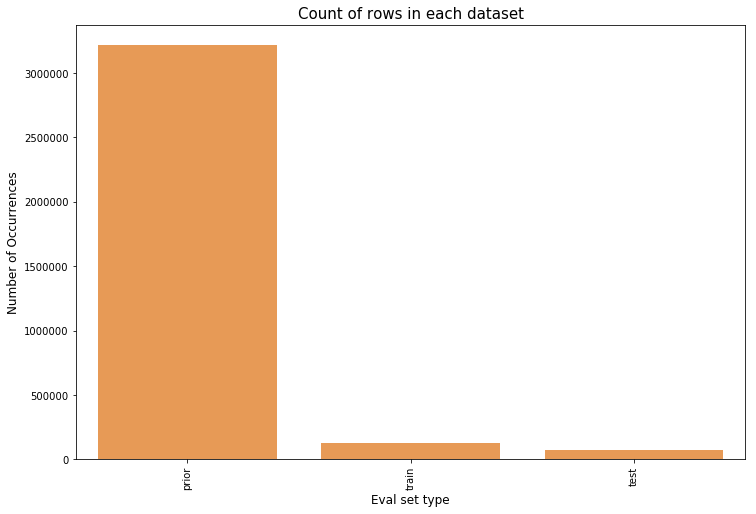

In [6]:
# counts of each dataset
cnt_srs = orders['eval_set'].value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [7]:
# number of users in each dataset
cnt_srs = orders.groupby("eval_set")["user_id"].nunique()
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

So there are 206,209 customers in total. Out of which, the last purchase of 131,209 customers are given as train set and we need to predict for the rest 75,000 customers.
Now let us validate the claim that 4 to 100 orders of a customer are given.

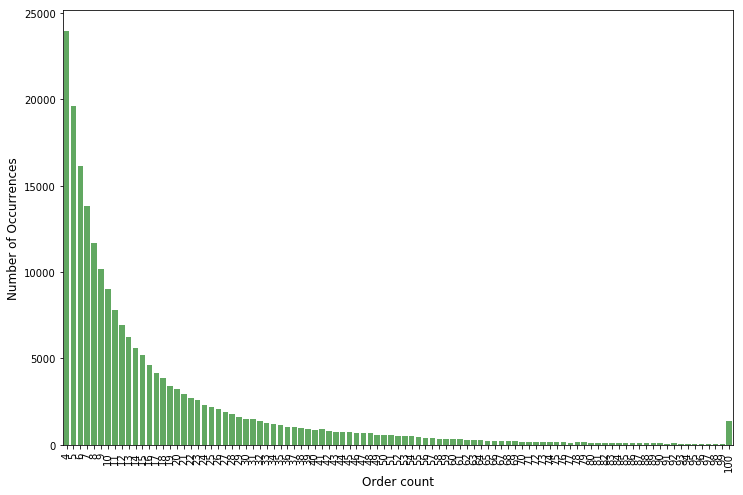

In [8]:
# order count for each user
cnt_srs = orders.groupby("user_id")["order_number"].count().reset_index(name = 'order count')
cnt_srs = cnt_srs['order count'].value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Order count', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

So there are no orders less than 4 and is max capped at 100 as given in the data page.
Now let us see how the ordering habit changes with day of week.

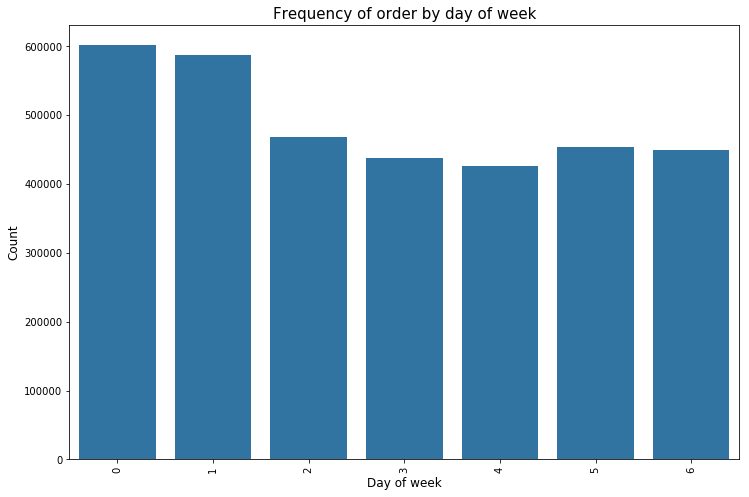

In [9]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by day of week", fontsize=15)
plt.show()

Seems like 0 and 1 is Saturday and Sunday when the orders are high and low during Wednesday.
Now we shall see how the distribution is with respect to time of the day.

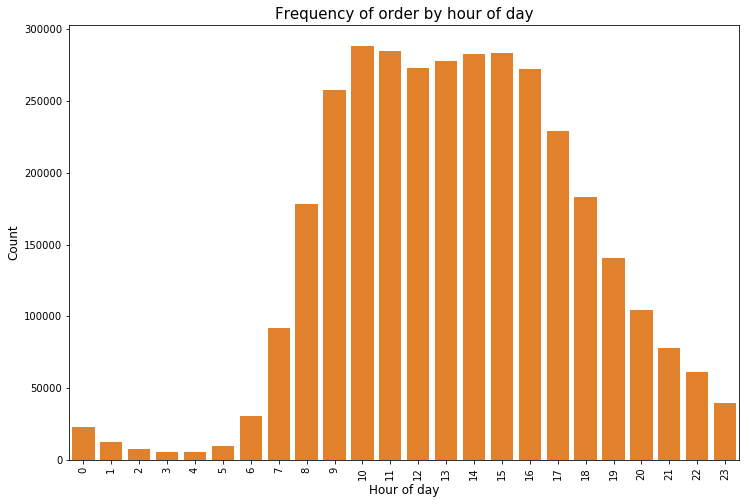

In [10]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

So majority of the orders are made during day time. Now let us combine the day of week and hour of day to see the distribution.

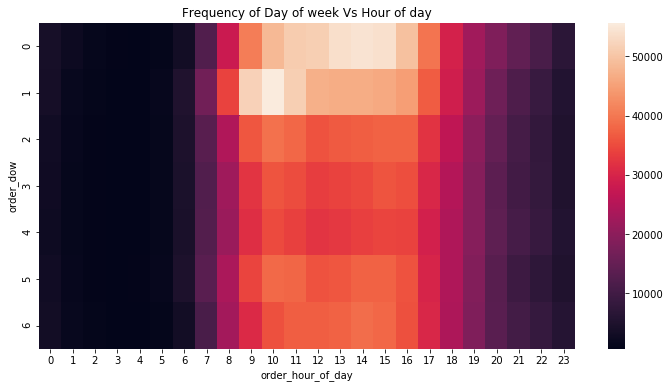

In [11]:
# counts of the day of the week combined with hour of day 
grouped_df = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].count().reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

Seems Satuday evenings and Sunday mornings are the prime time for orders.
Now let us check the time interval between the orders.

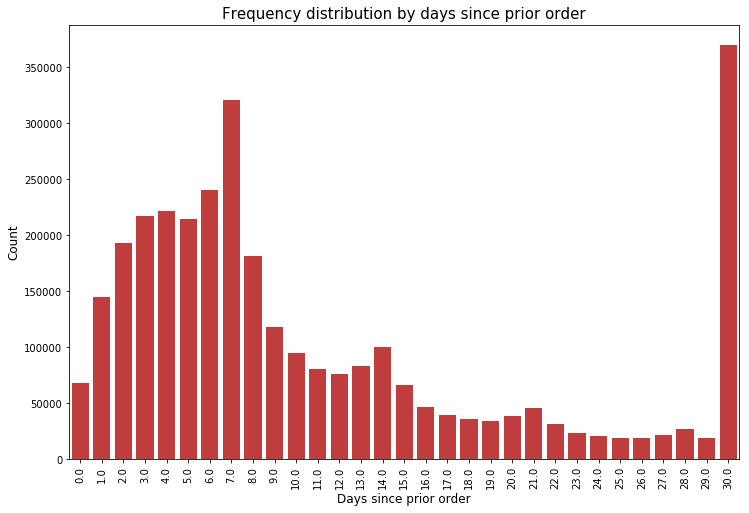

In [12]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

Looks like customers order once in every week (check the peak at 7 days) or once in a month (peak at 30 days). We could also see smaller peaks at 14, 21 and 28 days (weekly intervals).
Since our objective is to figure out the re-orders, let us check out the re-order percentage in prior set and train set.

In [13]:
# percentage of re-orders in prior set
orders_prior['reordered'].sum() / orders_prior.shape[0]

0.5896974667922161

In [14]:
# percentage of re-orders in train set
orders_train['reordered'].sum() / orders_train.shape[0]

0.5985944127509629

On an average, about 59% of the products in an order are re-ordered products.
### No re-ordered products:
Now that we have seen 59% of the products in an order are re-ordered, there will also be situations when none of the products are re-ordered. Let us check that now.

In [15]:
# persentage of orders that have no reordered items for the prior dataset
grouped_df = orders_prior.groupby("order_id")["reordered"].sum().reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [16]:
# persentage of orders that have no reordered items for the train dataset
grouped_df = orders_train.groupby("order_id")["reordered"].sum().reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.93444
0    0.06556
Name: reordered, dtype: float64

About 12% of the orders in prior set has no re-ordered items while in the train set it is 6.5%.
Now let us see the number of products bought in each order.

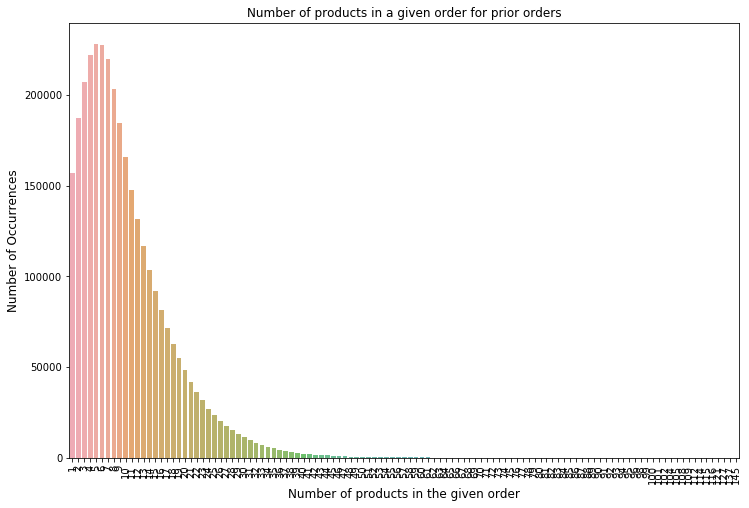

In [17]:
# counts of the number of products per order for the prior dataset
grouped_df = orders_prior.groupby("order_id")['product_id'].count().reset_index(name='product_count')
cnt_srs = grouped_df['product_count'].value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.title('Number of products in a given order for prior orders')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

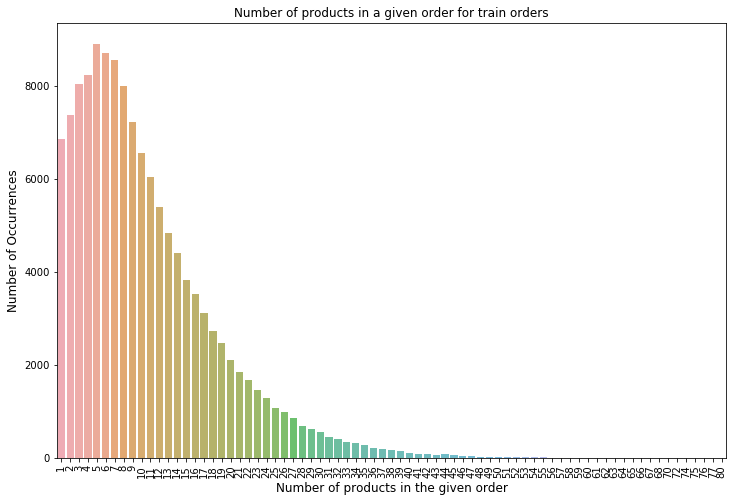

In [18]:
# counts of the number of products per order for the train dataset
grouped_df = orders_train.groupby("order_id")['product_id'].count().reset_index(name='product_count')
cnt_srs = grouped_df['product_count'].value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.title('Number of products in a given order for train orders')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

A right tailed distribution with the maximum value at about 5
Before we explore the product details, let us look at the other three files as well.

In [19]:
# first 5 rows of products
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [20]:
# first 5 rows of departments
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [21]:
# first 5 rows of aisles
Aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


Now let us merge these product details with the orders and the order_prior details 

In [22]:
#Combine the Data sources and drop the unused data such as eval_set

orders_prior = orders[orders['eval_set'] == 'prior'].merge(orders_prior, on='order_id', how='left')\
.merge(products, on='product_id', how='left').merge(departments, on='department_id', how='left')\
.merge(Aisles, on='aisle_id', how='left').drop(['eval_set'], axis = 1)
orders_prior.fillna(0, inplace = True)
orders_prior.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2539329,1,1,2,8,0.0,196,1,0,Soda,77,7,beverages,soft drinks
1,2539329,1,1,2,8,0.0,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,dairy eggs,soy lactosefree
2,2539329,1,1,2,8,0.0,12427,3,0,Original Beef Jerky,23,19,snacks,popcorn jerky
3,2539329,1,1,2,8,0.0,26088,4,0,Aged White Cheddar Popcorn,23,19,snacks,popcorn jerky
4,2539329,1,1,2,8,0.0,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,household,paper goods


 Lests count the top 20 brought products

In [23]:
# counts of the top 20 products
cnt_srs = orders_prior['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


Most of them are organic products.! Also majority of them are fruits.
Now let us look at the important aisles.

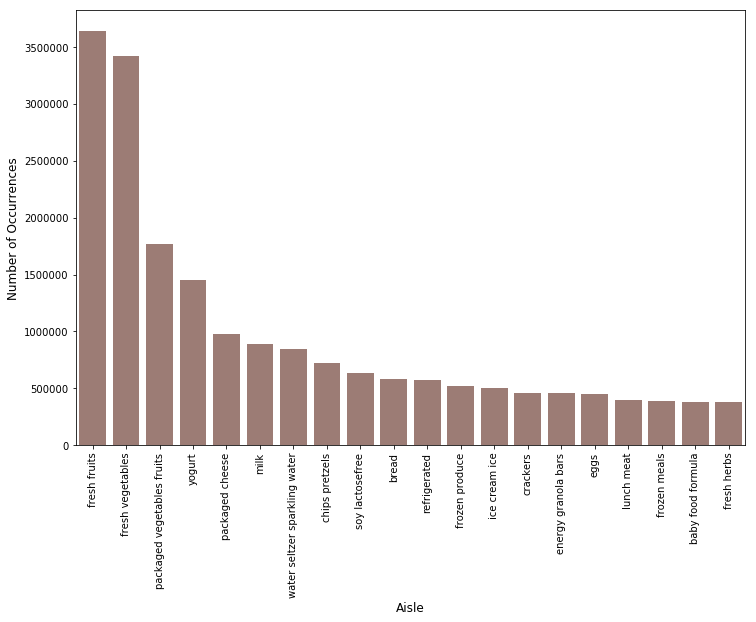

In [24]:
# counts of top 20 aisles 
cnt_srs = orders_prior['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

The top two aisles are fresh fruits and fresh vegetables.
### Department Distribution:
Let us now check the department wise distribution

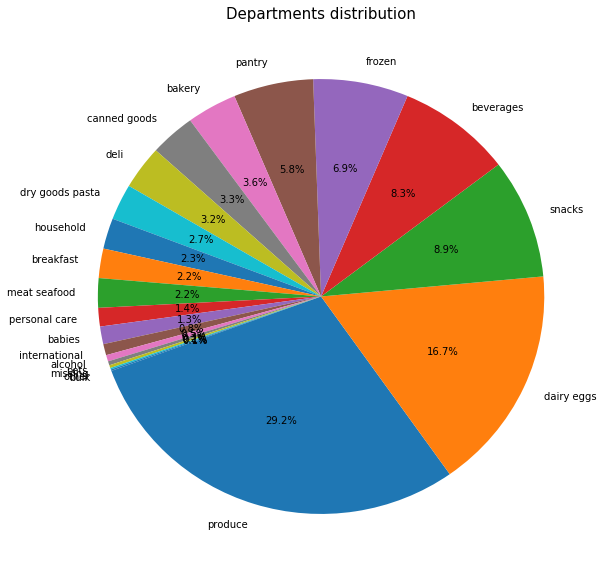

In [25]:
# department distribution
plt.figure(figsize=(10,10))
temp_series = orders_prior['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

Produce is the largest department. Now let us check the reordered percentage of each department.
Department wise reorder ratio:

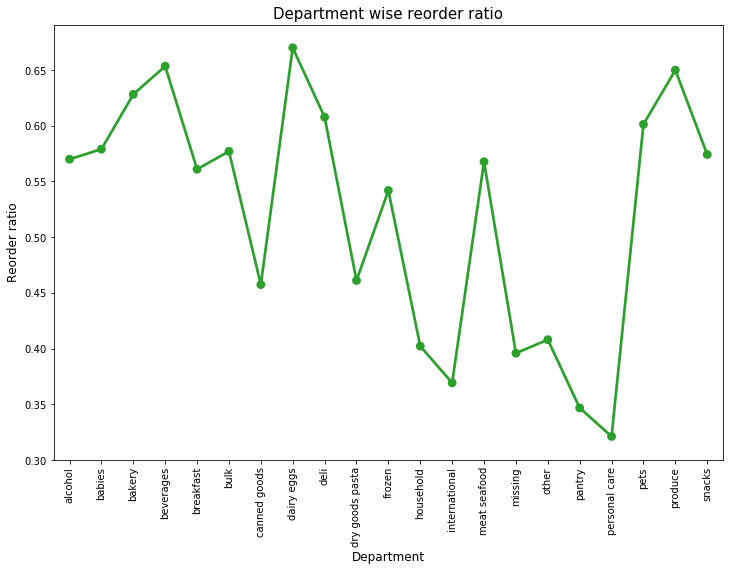

In [26]:
# the ratio of the number of reordered items form a department to the total form that department.
# mean is directly used as 'reordered' can only be 0 or 1
grouped_df = orders_prior.groupby(["department"])["reordered"].mean().reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

Personal care has lowest reorder ratio and dairy eggs have highest reorder ratio.
Aisle - Reorder ratio:

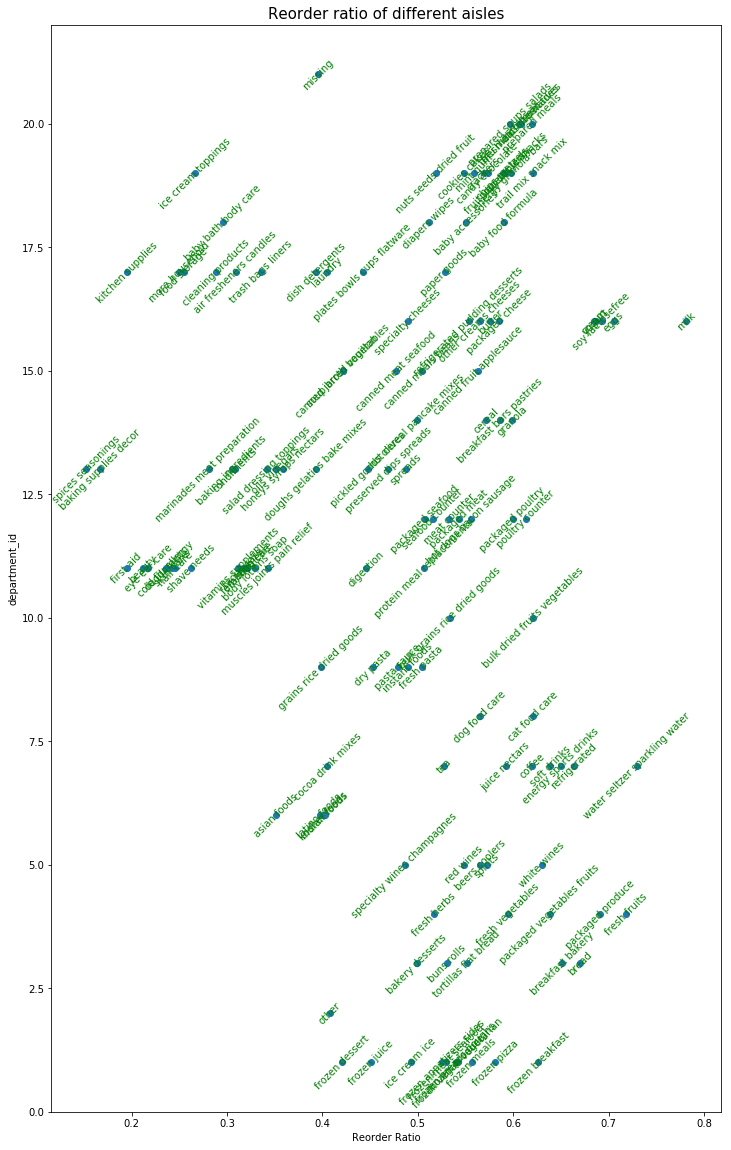

In [27]:
# the ratio of the number of reordered items form an aisle to the total form that aisle.
grouped_df = orders_prior.groupby(["department_id", "aisle"])["reordered"].mean().reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

### Add to Cart - Reorder ratio:
Let us now explore the relationship between how order of adding the product to the cart affects the reorder ratio.

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


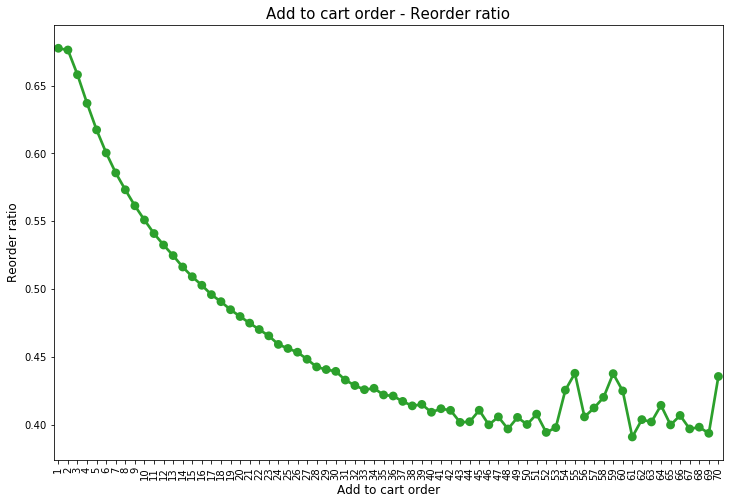

In [28]:
# ratio of reordered items by 'add_to_cart_order' column. 70 is set as the max value for add_to_cart_order > 70
orders_prior["add_to_cart_order_mod"] = orders_prior["add_to_cart_order"].copy()
orders_prior["add_to_cart_order_mod"].loc[orders_prior["add_to_cart_order_mod"]>70] = 70
grouped_df = orders_prior.groupby(["add_to_cart_order_mod"])["reordered"].mean().reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

Looks like the products that are added to the cart initially are more likely to be reordered again compared to the ones added later. Lets look at Reorder ratio by Time based variables:

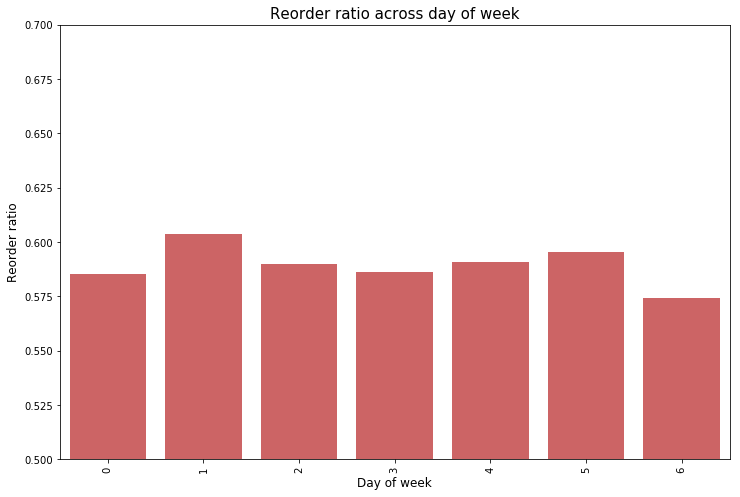

In [29]:
# the reorder ratio by 'order_dow' (day of week) column
grouped_df = orders_prior.groupby(["order_dow"])["reordered"].mean().reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

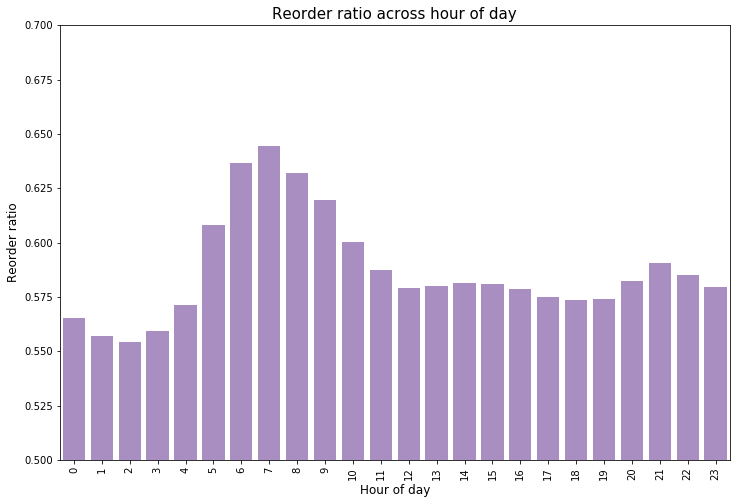

In [30]:
# the reorder ratio by 'order_hour_of_day' column
grouped_df = orders_prior.groupby(["order_hour_of_day"])["reordered"].mean().reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

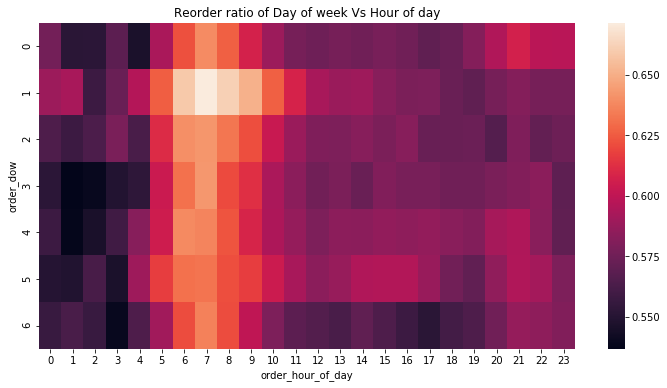

In [31]:
# the reorder ratio by grouped 'order_dow' 'order_hour_of_day' columns
grouped_df = orders_prior.groupby(["order_dow", "order_hour_of_day"])["reordered"].mean().reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

Looks like reorder ratios are quite high during the early mornings compared to later half of the day.

### Features

lets generate all the features that will be use to train and test the data. First lets start with the products

In [32]:
#Generate all of the features that will be use to train and test the data by product and user

# the total number of ordered products for each user
total_ordered_products = orders_prior.groupby(['user_id']).size().reset_index(name = 'total_ordered_products')

# the total number of orders for each users
total_orders = orders_prior.groupby(['user_id'])['order_id'].nunique().reset_index(name = 'total_orders')

# the total number of different distinct products for each user
total_distinct_products = orders_prior.groupby(['user_id'])['product_id'].nunique().reset_index(name = 'total_distinct_products')

# the average amount of each product the user ordered based on the user, the product and the number of orders for each user
order_rate_per_user_per_product = orders_prior.groupby(['user_id', 'product_id']).size()\
.reset_index(name = 'user_total_prod_order').merge(total_orders, on = 'user_id')
order_rate_per_user_per_product['order_rate_per_user_per_product'] = order_rate_per_user_per_product['user_total_prod_order']\
/order_rate_per_user_per_product['total_orders']
order_rate_per_user_per_product.drop(['total_orders'], axis = 1, inplace = True)

# the average order rate per product based on the prodct only
order_rate_per_product = orders_prior.groupby(['product_id']).size().reset_index(name = 'total_prod_order')
order_rate_per_product['total_orders'] = orders_prior['order_id'].nunique()
order_rate_per_product['order_rate_per_product'] = order_rate_per_product['total_prod_order']\
/order_rate_per_product['total_orders']
order_rate_per_product.drop(['total_orders'], axis = 1, inplace = True)

# a temp dataframe to store the number of times a product was ordered for a second time (equal to the different 
# users who ordered the product more than once) and the number of times a product has been reordered
t = orders_prior[orders_prior['reordered'] == 1].groupby(['product_id'], as_index=False)\
.agg({'user_id': 'nunique', 'reordered': 'count'})\
.rename(columns={'user_id': 'prod_buy_second_time_count', 'reordered': 'prod_reordered_count'})
# stores diffrent ratios between products and the order count
prior_order_ratios = orders_prior[orders_prior['reordered'] == 0].groupby(['product_id']).size()\
.reset_index(name = 'prod_buy_first_time_count').merge(t, on = 'product_id', how = 'left')
prior_order_ratios['prod_buy_second_time_count'].fillna(0, inplace = True)

# the ratio of the number of times a product was reordered for a second time (second_order_sum) over the number 
# of times a product was ordered for the first time (first_order_sum)
prior_order_ratios['prod_reorder_rate'] =\
prior_order_ratios['prod_buy_second_time_count']/prior_order_ratios['prod_buy_first_time_count']

# the total number of times a product was reordered over the total number of times a product was ordered
prior_order_ratios['prod_reorder_ratio'] = prior_order_ratios['prod_reordered_count']/order_rate_per_product['total_prod_order']

# delete t
del t

# used for getting the count of orders since last order for a product and the order rate for a product since the first order
# for each user
order_rate_since_order = orders_prior.groupby(['user_id','product_id'])['order_number']\
.agg(['count','min','max']).reset_index().rename(columns = {'min': 'prod_first_order_number', 'max': 'prod_last_order_number'})
order_rate_since_order = order_rate_since_order.merge(total_orders, on = 'user_id')

# the number of orders since the the last order of a product for each user
order_rate_since_order['up_prod_order_since_last_order'] =\
order_rate_since_order['total_orders'] - order_rate_since_order['prod_last_order_number']

# the ratio of the order count of a product to the number of orders after and including the first order of a product for each user
order_rate_since_order['up_prod_order_rate_since_first_order'] = order_rate_since_order['count']/\
(order_rate_since_order['total_orders'] - order_rate_since_order['prod_first_order_number'] + 1)

# drop unused columns
order_rate_since_order.drop(['count','total_orders'], axis = 1, inplace = True)

then the departments

In [33]:
#Generate all of the features that will be use to train and test the data by department, and user

# the total number of different distinct departments for each user
total_distinct_deps = orders_prior.groupby(['user_id'])['department_id'].nunique()\
.reset_index(name = 'total_distinct_deps')

# the average amount of each department the user ordered from based on the user, the department
# and the number of orders for each user
order_rate_per_user_per_dep = orders_prior.groupby(['user_id', 'department_id']).size()\
.reset_index(name = 'user_total_dep_order').merge(total_orders, on = 'user_id')
order_rate_per_user_per_dep['order_rate_per_user_per_dep'] = \
order_rate_per_user_per_dep['user_total_dep_order']/order_rate_per_user_per_dep['total_orders']
order_rate_per_user_per_dep.drop(['total_orders'], axis = 1, inplace = True)

# the average order rate per department based on the department only
order_rate_per_dep = orders_prior.groupby(['department_id']).size().reset_index(name = 'total_dep_order')
order_rate_per_dep['total_orders'] = orders_prior['order_id'].nunique()
order_rate_per_dep['order_rate_per_dep'] = \
order_rate_per_dep['total_dep_order']/order_rate_per_dep['total_orders']
order_rate_per_dep.drop(['total_orders'], axis = 1, inplace = True)

# a temp dataframe to store the number of times a department was ordered for a second time (equal to the different 
# users who ordered from the department more than once) and the number of times a department has been reordered from
t = orders_prior[orders_prior['reordered'] == 1].groupby(['department_id'], as_index=False)\
.agg({'user_id': 'nunique', 'reordered': 'count'})\
.rename(columns={'user_id': 'dep_buy_second_time_count', 'reordered': 'dep_reordered_count'})

# stores diffrent ratios between departments and the order count
prior_dep_order_ratios = orders_prior[orders_prior['reordered'] == 0].groupby(['department_id']).size()\
.reset_index(name = 'dep_buy_first_time_count').merge(t, on = 'department_id', how = 'left')
prior_dep_order_ratios['dep_buy_second_time_count'].fillna(0, inplace = True)

# the ratio of the number of times a department was reordered for a second time (second_order_sum) over the number 
# of times a department was ordered for the first time (first_order_sum)
prior_dep_order_ratios['dep_reorder_rate'] =\
prior_dep_order_ratios['dep_buy_second_time_count']/prior_dep_order_ratios['dep_buy_first_time_count']

# the total number of times a department was reordered over the total number of times a department was ordered
prior_dep_order_ratios['dep_reorder_ratio'] = \
prior_dep_order_ratios['dep_reordered_count']/order_rate_per_dep['total_dep_order']

# del t
del t

# used for getting the count of orders since last order form a department and the order rate for a department 
# since the first order for each user
order_dep_rate_since_order = orders_prior.groupby(['user_id','department_id'])['order_number'].agg(['count','min','max'])\
.reset_index().rename(columns = {'min': 'dep_first_order_number', 'max': 'dep_last_order_number'})
order_dep_rate_since_order = order_dep_rate_since_order.merge(total_orders, on = 'user_id')

# the number of orders since the the last order from a department for each user
order_dep_rate_since_order['up_dep_order_since_last_order'] =\
order_dep_rate_since_order['total_orders'] - order_dep_rate_since_order['dep_last_order_number']

# the ratio of the order count from a department to the number of orders after 
# and including the first order from a department for each user
order_dep_rate_since_order['up_dep_order_rate_since_first_order'] = order_dep_rate_since_order['count']/\
(order_dep_rate_since_order['total_orders'] - order_dep_rate_since_order['dep_first_order_number'] + 1)

# drop unused columns
order_dep_rate_since_order.drop(['count','total_orders'], axis = 1, inplace = True)

then the asiles

In [34]:
#Generate all of the features that will be use to train and test the data by aisle, and user

# the total number of different distinct aisle for each user
total_distinct_aisles = orders_prior.groupby(['user_id'])['aisle_id'].nunique()\
.reset_index(name = 'total_distinct_aisles')

# the average amount of each aisle the user ordered from based on the user, the aisle
# and the number of orders for each user
order_rate_per_user_per_aisle = orders_prior.groupby(['user_id', 'aisle_id']).size()\
.reset_index(name = 'user_total_aisle_order') .merge(total_orders, on = 'user_id')
order_rate_per_user_per_aisle['order_rate_per_user_per_aisle'] = \
order_rate_per_user_per_aisle['user_total_aisle_order']/order_rate_per_user_per_aisle['total_orders']
order_rate_per_user_per_aisle.drop(['total_orders'], axis = 1, inplace = True)

# the average order rate per aisle based on the aisle only
order_rate_per_aisle = orders_prior.groupby(['aisle_id']).size().reset_index(name = 'total_aisle_order')
order_rate_per_aisle['total_orders'] = orders_prior['order_id'].nunique()
order_rate_per_aisle['order_rate_per_aisle'] = \
order_rate_per_aisle['total_aisle_order']/order_rate_per_aisle['total_orders']
order_rate_per_aisle.drop(['total_orders'], axis = 1, inplace = True)

# a temp dataframe to store the number of times an aisle was ordered for a second time (equal to the different 
# users who ordered from the aisle more than once) and the number of times an aisle has been reordered from
t = orders_prior[orders_prior['reordered'] == 1].groupby(['aisle_id'], as_index=False)\
.agg({'user_id': 'nunique', 'reordered': 'count'})\
.rename(columns={'user_id': 'aisle_buy_second_time_count', 'reordered': 'aisle_reordered_count'})

# stores diffrent ratios between aisles and the order count
prior_aisle_order_ratios = orders_prior[orders_prior['reordered'] == 0].groupby(['aisle_id']).size()\
.reset_index(name = 'aisle_buy_first_time_count').merge(t, on = 'aisle_id', how = 'left')
prior_aisle_order_ratios['aisle_buy_second_time_count'].fillna(0, inplace = True)

# the ratio of the number of times an aisle was reordered for a second time (second_order_sum) over the number 
# of times an aisle was ordered for the first time (first_order_sum)
prior_aisle_order_ratios['aisle_reorder_rate'] =\
prior_aisle_order_ratios['aisle_buy_second_time_count']/prior_aisle_order_ratios['aisle_buy_first_time_count']

# the total number of times an aisle was reordered over the total number of times an aisle was ordered
prior_aisle_order_ratios['aisle_reorder_ratio'] = \
prior_aisle_order_ratios['aisle_reordered_count']/order_rate_per_aisle['total_aisle_order']

# del t and drop uunsed columns
del t

# used for getting the count of orders since last order form an aisle and the order rate for an aisle 
# since the first order for each user
order_aisle_rate_since_order = orders_prior.groupby(['user_id','aisle_id'])['order_number'].agg(['count','min','max'])\
.reset_index().rename(columns = {'min': 'aisle_first_order_number', 'max': 'aisle_last_order_number'})
order_aisle_rate_since_order = order_aisle_rate_since_order.merge(total_orders, on = 'user_id')

# the number of orders since the the last order from an aisle for each user
order_aisle_rate_since_order['up_aisle_order_since_last_order'] =\
order_aisle_rate_since_order['total_orders'] - order_aisle_rate_since_order['aisle_last_order_number']

# the ratio of the order count from an aisle to the number of orders after 
# and including the first order from an aisle for each user
order_aisle_rate_since_order['up_aisle_order_rate_since_first_order'] = order_aisle_rate_since_order['count']/\
(order_aisle_rate_since_order['total_orders'] - order_aisle_rate_since_order['aisle_first_order_number'] + 1)

# drop unused columns
order_aisle_rate_since_order.drop(['count','total_orders'], axis = 1, inplace = True)

lets also generate features for the day of week, hour of the day, days between orders, the reorder and none reorder rates,
the add to cart order and the average order or cart size for each user.

In [35]:
#Generate the rest of the features

# the mean of an order's day of the week for each use
med_order_dow = orders_prior.groupby(['user_id'])['order_dow'].mean().reset_index(name = 'med_order_dow')

# the mean of an order's hour of the day for each user
med_order_hour_of_day = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['order_hour_of_day'].mean()\
.reset_index(name = 'med_order_hour_of_day')

# the sum of the days since prior order for each user
sum_days_since_prior_order = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['days_since_prior_order'].sum()\
.reset_index(name = 'sum_days_since_prior_order')

# the mean of the days since prior order for each user
med_days_since_prior_order = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['days_since_prior_order'].mean()\
.reset_index(name = 'med_days_since_prior_order')

# the next few lines calculate the average number of days between each order of a product for each user
avg_days_bet_prod_order = orders[orders['eval_set'] == 'prior'][['user_id','order_number','days_since_prior_order']].fillna(0)
avg_days_bet_prod_order['avg_days_bet_prod_order'] = avg_days_bet_prod_order.groupby(['user_id'])\
['days_since_prior_order'].cumsum()
avg_days_bet_prod_order = avg_days_bet_prod_order.merge(orders_prior[['user_id','order_number','product_id', 'reordered']],\
                                                        on = ['user_id', 'order_number'])

avg_days_bet_prod_order.sort_values(['user_id', 'product_id', 'order_number'], inplace = True)
avg_days_bet_prod_order['avg_days_bet_prod_order'] = avg_days_bet_prod_order['avg_days_bet_prod_order'].diff()

avg_days_bet_prod_order = avg_days_bet_prod_order[avg_days_bet_prod_order['reordered'] == 1].groupby(['user_id','product_id'])\
['avg_days_bet_prod_order'].mean().reset_index(name = 'avg_days_bet_prod_order')

# the reorder rate for a user which is the sum of the amount of reorders of all reordered products 
# over the count of all ordered product where order number is > 1 for each user
reorder_rate = orders_prior[orders_prior['order_number'] > 1].groupby(['user_id'])['reordered'].count()\
.reset_index(name = 'reorder_rate')
reorder_rate['reorder_rate'] = orders_prior.groupby(['user_id'], as_index = False)['reordered'].sum()['reordered']\
/ reorder_rate['reorder_rate']

# none_reorder_rate which is the number of orders where user has not reordered a product for all users
none_reorder_rate = orders_prior.groupby(['user_id','order_number'])['reordered'].sum().reset_index(name = 'none_reorders')
none_reorder_rate = none_reorder_rate[none_reorder_rate['none_reorders'] == 0].groupby(['user_id'])['none_reorders'].count()\
.reset_index(name = 'none_reorder_rate') 
none_reorder_rate['none_reorder_rate'] = none_reorder_rate['none_reorder_rate'] / total_orders['total_orders']

# mean add to cart number for each product
med_cart_number_per_prod = orders_prior.groupby(['product_id'])['add_to_cart_order'].mean()\
.reset_index(name = 'med_cart_number_per_prod')

# mean add to cart number per product for each user
med_cart_number_per_user_per_prod = orders_prior.groupby(['user_id','product_id'])['add_to_cart_order'].mean()\
.reset_index(name = 'med_cart_number_per_user_per_prod')

# the cart number of the last order of a product for each combination of user and product
last_cart_number_per_user_per_prod = orders_prior.sort_values('order_number', ascending=False)\
.drop_duplicates(['user_id','product_id'])[['user_id','product_id','add_to_cart_order']]\
.rename(columns = {'add_to_cart_order': 'add_to_cart_last_order'})

# the average nuumber of products per order (or the average cart size) for each user by diving the total amount of products
# a user orders over the total number of orders for a user
avg_cart_size = total_ordered_products.copy()
avg_cart_size['avg_order_size'] = total_ordered_products['total_ordered_products'] / total_orders['total_orders']
avg_cart_size.drop(['total_ordered_products'], axis = 1, inplace = True)

Lets import and load the classifiers and other libraries that we might use for training and testing the data

In [36]:
# load classifiers and cross validation libraries which might be used for training and testing the data
import xgboost
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.linear_model import SGDClassifier, LinearRegression, LogisticRegression
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from F1_script.script import F1Optimizer


C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Lets combine the generated features with the train and test data and also split the training data into train and test for
cross validation

In [47]:
# combine features with training and testing data then 
# split train data into train and test for cross validation

train = pd.concat([total_ordered_products['user_id'], total_ordered_products['total_ordered_products'],\
                   total_orders['total_orders'],total_distinct_products['total_distinct_products'],\
                   total_distinct_deps['total_distinct_deps'], total_distinct_aisles['total_distinct_aisles'],\
                   reorder_rate['reorder_rate'], none_reorder_rate['none_reorder_rate'], med_order_dow['med_order_dow'],\
                   med_order_hour_of_day['med_order_hour_of_day'], med_days_since_prior_order['med_days_since_prior_order'],\
                   sum_days_since_prior_order['sum_days_since_prior_order'], avg_cart_size['avg_order_size']], axis = 1)

users_train = orders[orders['eval_set'] == 'train'].merge(orders_train, on='order_id', how='left')

users_train = users_train.merge(order_rate_per_user_per_product, on = ['user_id', 'product_id'], how = 'right')
users_train = users_train.merge(order_rate_per_product, on = 'product_id')
users_train = users_train.merge(prior_order_ratios, on = 'product_id')
users_train = users_train.merge(med_cart_number_per_prod, on = 'product_id')
users_train = users_train.merge(order_rate_since_order, on = ['user_id', 'product_id'])
users_train = users_train.merge(med_cart_number_per_user_per_prod, on = ['user_id', 'product_id'])
users_train = users_train.merge(last_cart_number_per_user_per_prod, on = ['user_id', 'product_id'])
users_train = users_train.merge(products, on = 'product_id')

# users_train = users_train.merge(order_rate_per_user_per_dep, on = ['user_id', 'department_id'])
# users_train = users_train.merge(order_rate_per_dep, on = 'department_id')
# users_train = users_train.merge(prior_dep_order_ratios, on = 'department_id')
# users_train = users_train.merge(order_dep_rate_since_order, on = ['user_id', 'department_id'])

# users_train = users_train.merge(order_rate_per_user_per_aisle, on = ['user_id', 'aisle_id'])
# users_train = users_train.merge(order_rate_per_aisle, on = 'aisle_id')
# users_train = users_train.merge(prior_aisle_order_ratios, on = 'aisle_id')
# users_train = users_train.merge(order_aisle_rate_since_order, on = ['user_id', 'aisle_id'])

users_train = users_train.merge(avg_days_bet_prod_order, on = ['user_id', 'product_id'], how = 'left')
users_train['avg_days_bet_prod_order'].fillna(0, inplace = True)

train1 = train.merge(users_train, on = 'user_id')
train1['reordered'].fillna(0, inplace = True)
train1['order_dow'] = train1.groupby(['user_id'])['order_dow'].transform(lambda x: x.mean())
train1['order_hour_of_day'] = train1.groupby(['user_id'])['order_hour_of_day'].transform(lambda x: x.mean())
train1['days_since_prior_order'] = train1.groupby(['user_id'])['days_since_prior_order'].transform(lambda x: x.mean())
    
train1.drop(['order_id','order_number','eval_set','add_to_cart_order'],\
            axis = 1, inplace = True)

users_test = orders[orders['eval_set'] == 'test'].drop(['eval_set','order_number'], axis = 1)

users_test = users_test.merge(order_rate_per_user_per_product, on = 'user_id')
users_test = users_test.merge(order_rate_per_product, on = 'product_id')
users_test = users_test.merge(prior_order_ratios, on = 'product_id')
users_test = users_test.merge(med_cart_number_per_prod, on = 'product_id')
users_test = users_test.merge(order_rate_since_order, on = ['user_id', 'product_id'])
users_test = users_test.merge(med_cart_number_per_user_per_prod, on = ['user_id', 'product_id'])
users_test = users_test.merge(last_cart_number_per_user_per_prod, on = ['user_id', 'product_id'])
users_test = users_test.merge(products, on = 'product_id')

# users_test = users_test.merge(order_rate_per_user_per_dep, on = ['user_id', 'department_id'])
# users_test = users_test.merge(order_rate_per_dep, on = 'department_id')
# users_test = users_test.merge(prior_dep_order_ratios, on = 'department_id')
# users_test = users_test.merge(order_dep_rate_since_order, on = ['user_id', 'department_id'])

# users_test = users_test.merge(order_rate_per_user_per_aisle, on = ['user_id', 'aisle_id'])
# users_test = users_test.merge(order_rate_per_aisle, on = 'aisle_id')
# users_test = users_test.merge(prior_aisle_order_ratios, on = 'aisle_id')
# users_test = users_test.merge(order_aisle_rate_since_order, on = ['user_id', 'aisle_id'])

users_test = users_test.merge(avg_days_bet_prod_order, on = ['user_id', 'product_id'], how = 'left')
users_test['avg_days_bet_prod_order'].fillna(0, inplace = True)

test1 = train.merge(users_test, on = 'user_id')
test1['order_dow'] = test1.groupby(['user_id'])['order_dow'].transform(lambda x: x.fillna(x.mean()))
test1['order_hour_of_day'] = test1.groupby(['user_id'])['order_hour_of_day'].transform(lambda x: x.fillna(x.mean()))
test1['days_since_prior_order'] = test1.groupby(['user_id'])['days_since_prior_order'].transform(lambda x: x.fillna(x.mean()))

X = train1['user_id'].unique()
y = np.zeros(X.shape)

X_train1, X_test1, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

X_train = train1.merge(pd.DataFrame(X_train1, columns = ['user_id']), on = 'user_id')
X_test = train1.merge(pd.DataFrame(X_test1, columns = ['user_id']), on = 'user_id')    
y_train = X_train['reordered'] 
y_test = X_test['reordered']
X_train = X_train.drop(['user_id','product_id','product_name','aisle_id','department_id','reordered'], axis=1)
X_test = X_test.drop(['product_name','aisle_id','department_id','reordered'], axis=1)


### Model:

We'll use xgboost model with objective binary:logistic and other prameters to train and test the training data according to our split and see how our model works. As I side note, some of the prameters where trained using gridsearchcv but it is not included here as it was tedious and took a very long time to complete.

[0]	train-logloss:0.211206
[10]	train-logloss:0.160152
[20]	train-logloss:0.148157
[30]	train-logloss:0.14288
[40]	train-logloss:0.139976
[50]	train-logloss:0.137948
[60]	train-logloss:0.136195
[70]	train-logloss:0.134425
[80]	train-logloss:0.13296
[90]	train-logloss:0.131714
[100]	train-logloss:0.130463
[110]	train-logloss:0.12901
[120]	train-logloss:0.127699
[130]	train-logloss:0.12616
[140]	train-logloss:0.124574
[150]	train-logloss:0.123165
[160]	train-logloss:0.121627
[170]	train-logloss:0.120264
[180]	train-logloss:0.119065
[190]	train-logloss:0.117591
[200]	train-logloss:0.11619
[210]	train-logloss:0.114627
[220]	train-logloss:0.11327
[230]	train-logloss:0.11201
[240]	train-logloss:0.110472
[250]	train-logloss:0.109009
[260]	train-logloss:0.107634
[270]	train-logloss:0.106407
[280]	train-logloss:0.104987
[290]	train-logloss:0.103676
[300]	train-logloss:0.102407
[310]	train-logloss:0.10109
[320]	train-logloss:0.09993
[330]	train-logloss:0.098738
[340]	train-logloss:0.097399
[350]

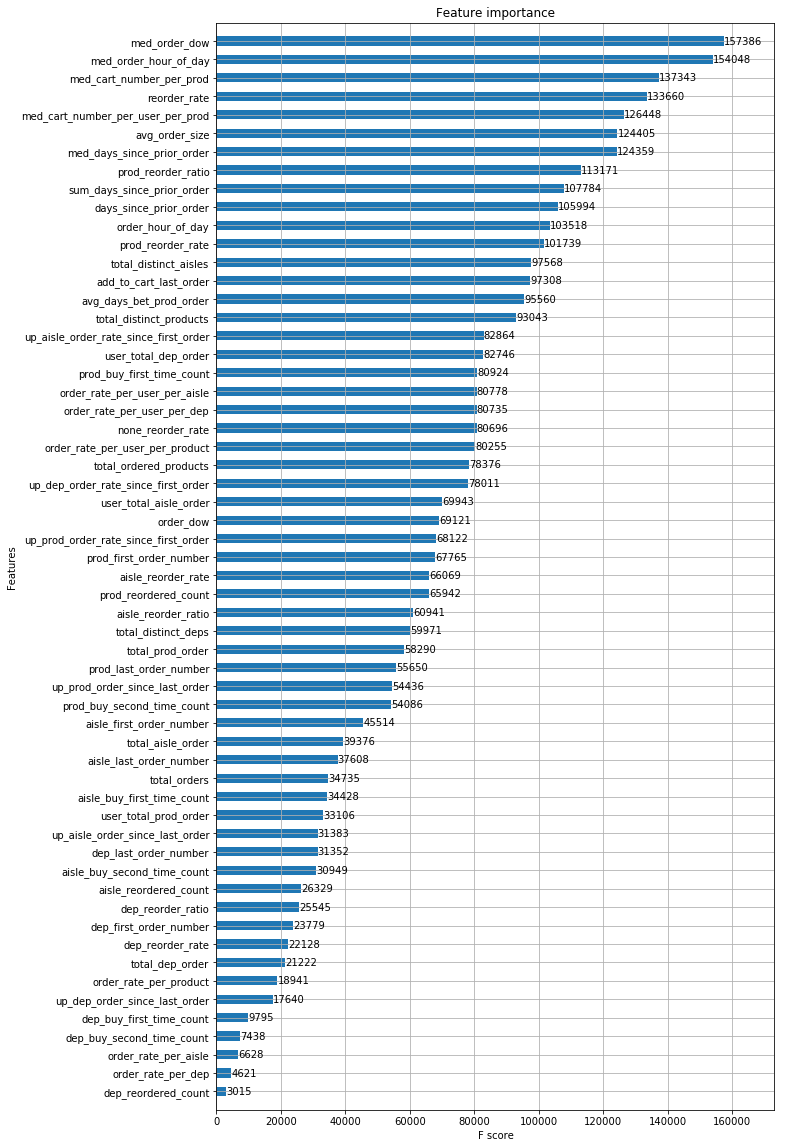

In [38]:
# use xgboost with specified parameters to train the data for cross validation

d_train = xgboost.DMatrix(X_train, y_train)

xgb_params = {
    "nthread"           : 4
    ,"objective"        : "binary:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 15
    ,"min_child_weight" : 4
    ,"gamma"            :0.2
    ,"subsample"        :0.8
    ,"colsample_bytree" :0.8
    ,"alpha"            :0.01
    ,"lambda"           :1
    ,"silent"           :0
    ,'base_score'       : y_train.mean()
}

watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=1000, evals=watchlist, verbose_eval=10)
# plot feature importance
fig, ax = plt.subplots(figsize = (10,20))
xgboost.plot_importance(bst, ax = ax, height = 0.5)

In [41]:
# test and predict the remaing part of the training data on the trained data

d_test = xgboost.DMatrix(X_test.drop(['user_id','product_id'], axis = 1))
preds=bst.predict(d_test)

### Scoring

Now, lets get the predicted resutls and compare it with current results and generate a final score based on F1 score. The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$
F1 = 2 * (precision * recall) / (precision + recall)
$$

In [42]:
# get the predict products purchased by the tested users on their last orders
# using the predicted probabilites and using the F1Ooptimizer tp try to maximaize the expected outcome

# predicted probabilites
X_test['reordered'] = preds.astype(float)
pred = []
# loop on the dataframe of the 'user_id' group inorder to get the predicted products for each user
for i, df in X_test.groupby(['user_id']):
    product2preds= df[['product_id', 'reordered']]
    product2preds.sort_values('reordered',ascending=False, inplace=True)
    probabilities=product2preds['reordered'].values.tolist()
    products=product2preds['product_id'].values.tolist()
    # Use Faron's F1-opitimize
    opt=F1Optimizer.maximize_expectation(probabilities)
    best_k=opt[0]
    pred = pred + [[df['user_id'].iloc[0],products[i],1] for i in range(best_k)]


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [43]:
# use the real results to compare it with the predicted results
tested = orders[orders['eval_set'] == 'train'].merge(orders_train, on='order_id', how='left')
tested = tested.merge(pd.DataFrame(X_test1, columns = ['user_id']), on = 'user_id')

In [ ]:
#Compute F1_Score and use it as a final score for how the trained model generalised to the tested data:
def f1_score(test, predict):
    predicted = test.merge(pd.DataFrame(predict, columns = ['user_id','product_id','predected']), \
                         how = 'outer', on = ['user_id', 'product_id'])
    predicted['predected'].fillna(0, inplace = True)
    predicted['reordered'].fillna(-1, inplace = True)

    true_positives = predicted[(predicted['predected'] == 1) & ((predicted['reordered'] == 1) | (predicted['reordered'] == 0))]\
    .shape[0]

    false_positives = predicted[predicted['reordered'] == -1].shape[0]

    false_negatives = predicted[predicted['predected'] == 0].shape[0]

    precision=float(true_positives)/(true_positives+false_positives)
    
    recall=float(true_positives)/(true_positives+false_negatives)

    F1_score = 2*((precision*recall)/(precision+recall))
      
    return F1_score
    
print("F1 Score: ",f1_score(tested,pred))

F1 Score:  0.3054136850956967


Now, we will train again on the model but using all of the train data then test it on the required test data, generate predicted
results and write the output to a csv submission file for online submission in the competition

[0]	train-logloss:0.61565
[10]	train-logloss:0.277838
[20]	train-logloss:0.192565
[30]	train-logloss:0.167024
[40]	train-logloss:0.158794
[50]	train-logloss:0.155934
[60]	train-logloss:0.154861
[70]	train-logloss:0.154398
[80]	train-logloss:0.154175
[90]	train-logloss:0.153993


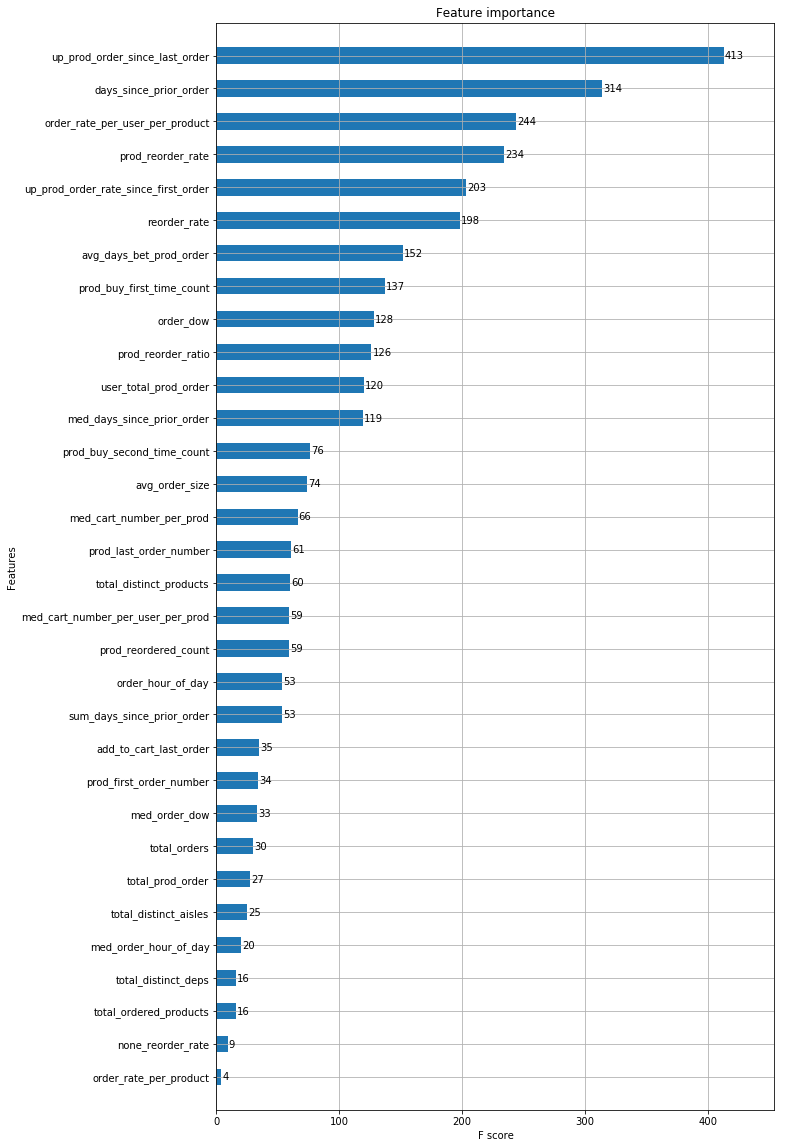

In [63]:
#train again on all the training data inorder to use it on the test data to generate predicted results for submission
d_train1 = xgboost.DMatrix(train1.drop(['user_id','product_id','product_name','aisle_id','department_id','reordered'],
                                       axis = 1), train1['reordered'])

xgb_params = {
    "nthread"           : 4
    ,"objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}
watchlist= [(d_train1, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train1, num_boost_round=100, evals=watchlist, verbose_eval=10)
# plot feature importance
fig, ax = plt.subplots(figsize = (10,20))
xgboost.plot_importance(bst, ax = ax, height = 0.5)

In [65]:
# predict the results of the test data
d_test = xgboost.DMatrix(test1.drop(['user_id','order_id','product_id','product_name','aisle_id','department_id',\
                                     'reorders'], axis = 1))
preds = bst.predict(d_test)

In [66]:
# get the predict products purchased by the tested user data on their last orders
# using the predicted probabilites and using the F1Ooptimizer tp try to maximaize the expected outcome

# predicted probabilites
test1['reorders'] = preds.astype(float)
#sort by the 'order_id' as the submission results should be sorted according to the 'order_id'
test1.sort_values('order_id',  inplace = True)
pred = []
# loop on the dataframe of the 'order_id' group inorder to get the predicted products for each order. 'order_id' is used in-order
# to return results sorted by the 'order_id' and it is similar to 'user_id' as there is one unique last order per user.
for i, df in test1.groupby(['order_id']):
    product2preds= df[['product_id', 'reorders']]
    product2preds.sort_values('reorders',ascending=False, inplace=True)
    probabilities=product2preds['reorders'].values.tolist()
    products=product2preds['product_id'].values.tolist()
    # Use Faron's F1-opitimize
    opt=F1Optimizer.maximize_expectation(probabilities)
    best_k=opt[0]
    pred.append([int(df['order_id'].iloc[0])] + products[:best_k])
    if(opt[1]):
        pred[len(pred)-1].append('None')


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [67]:
# output predicted results to a comma seperated file for submission

import csv

with open("test_submit.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(['order_id', 'products'])
    for i in range(len(pred)):
        s = str(pred[i][1])
        for j in range(2,len(pred[i])):
            s += ' ' + str(pred[i][j])
            
        writer.writerow([pred[i][0],s])